# Prediction of turtle sex with Machine Learning

What machine learning algorithms do is - in principle - very simple: they are fed with data, that they use to define a *decision surface*, mainly used to cluster or tag new/unknown data. We're going to use turtle shells metrics to try and predict turtles sex.

**Supervised** algorithms make use of labelled data, **unsupervised** ones try to cluster the data by the means of mathematics and distance parameters.

To start scratching the surface, I recommend the following Udemy's course:
https://classroom.udacity.com/courses/ud120

### What we will learn

With Python' we'll get to making predictions on actual data, by leveraging Principal Component Analisys (PCA) and Machine Learning (ML) algorithms.

This is a very tiny dataset, but comes from real data, it's handy to work with and it is as good as any as a starter for learning _sklearn_ syntax.

Explanation of the inner clockwork of each ML algorithm as well as algorithm comparison is beyond the scope of this notebook.

### Prerequisites
The PCA data walkthrough can be found at:
https://github.com/Stemanz/python_tutorials/tree/master/PCA

In [1]:
import pandas as pd
import numpy as np

# plotting
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

sep = "\t"

While already discussed, we're loading and PCA-transforming our real-world dataset from scratch:

In [2]:
# ===========================================================
# prepping the data with PCA. Full walkthrough:
# https://github.com/Stemanz/python_tutorials/tree/master/PCA
# ===========================================================
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# load data
df = pd.read_csv("turtles.csv", sep=sep)

# scale data
features = ["length", "width", "height"]
x = df.loc[:, features].values
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # int64 to float64 warning suppression
    x = StandardScaler().fit_transform(x)
    dfx = pd.DataFrame(x, columns=features) # back to a dataframe

# PCA dimensionality reduction: 3 to 2
pca = PCA(n_components=2, whiten=True)
PC = pca.fit_transform(x)
dfPC = pd.DataFrame(PC, columns=["PC1", "PC2"])
dfPC["Sex"] = df["Sex"] # retrieving sex info

# the dataset is now ready!

## Data preprocessing

### Dataset splitting into training and testing

To compare a few ML algorithms, we're going to split our dataset in two: we'll be using 75% of  our entries to *train* the algorithm, that will subsequently try and predict the labels of our data.

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dfPC, test_size=.25)

test.head()

,PC1,PC2,Sex
6,-0.052810,0.054038,F
23,2.662548,-1.078732,F
8,0.498425,0.336818,F
15,1.129025,0.965059,F
40,-0.501984,-1.417546,M


*train_test_split* spits back the same _type_ of container it was fed with, so we get back a DataFrame. We now have to transform data according to what _sklearn_ expects, that is:
- data as [[float64, float64], ...] array
- numerical labels

To get the job done quickly, it is better to write down a function that gives back all the stuff we want organized the way we want it.

**Note**: I'll be making use of *np.reshape*, a Numpy function that comes in handy when in need to reshaping vectors into subvectors. I strongly recommend you to tamper with it by making an array - say, *np.array(range(40))* - , and feed it to *np.reshape* asking for varying geometries, to see what it spits out. Read the doc with *help(np.reshape)*. Pay attention that the new shape parameter expects a *tuple*.

In [4]:
def split_dataset(df, labels={"M": 0, "F": 1}, test_size=.25):
    """
    This functions works with turtle dataset csv. It splits the dataset into
    train and test data and labels.
    M is sex 0, F is sex 1
    
    Returns:
    train_data, train_labels, test_data, test_labels
    """
    train, test = train_test_split(dfPC, test_size=test_size, random_state=123456)
    
    # using np.reshape to construct the numpy array.
    train_data = np.array(np.reshape(train.iloc[:, [0,1]], (train.shape[0],2)))
    test_data  = np.array(np.reshape(test.iloc[:, [0,1]], (test.shape[0],2)))
    
    # for more complicated label conversions pass custom dict
    train_labels = [labels.get(x) for x in train["Sex"]]
    test_labels  = [labels.get(x) for x in test["Sex"]]
    
    return train_data, train_labels, test_data, test_labels

In [5]:
train_data, train_labels, test_data, test_labels = split_dataset(dfPC)

Now the data is arranged how *sklearn* wants. Here's what train data and labels look like now:

In [6]:
train_data[:5]

array([[-1.15773848,  0.80754832],
       [ 0.41858888,  0.88961967],
       [ 1.83308617,  1.00956637],
       [-0.82921809,  0.28526912],
       [-0.68077941, -0.40473887]])

In [7]:
train_labels[:5]

[1, 1, 1, 1, 0]

## Supervised ML algorithms

### Naïve Bayes

For each algorithm, if you are interested in the inner workings or the parameters, watch some youtube videos and read *sklearn* documentation. In here I'll cover **how they are deployed**.

In [8]:
from sklearn.naive_bayes import GaussianNB # NB stands for Naïve Bayes

# training
clf = GaussianNB()
clf.fit(train_data, train_labels)

# predicting
pred_labels = clf.predict(test_data)

Conveniently, different ML algorithms do have the same syntax. The class is instantiated by calling it (with or withour parameters), then it is fitted with **.fit()**.
Predictions are made via **.predict()**.

If the array is conveniently shaped, it is possible to batch-predict stuff. Also individual points can be predicted, for instance:

In [9]:
clf.predict([[ 0.02736815,  2.47830153]]) # note the double square brackets

array([1])

#### Checking the accuracy of predictions

It is crucial to determine the accuracy of the model. _sklearn_ provides a tool that is cross-algorithm.

In [10]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(pred_labels, test_labels)
print(round(acc*100, 2), "%", sep="")

91.67%


Without any help and by just using real world measures and labels, the trained algorithm was able to correctly predict the sex of 91% unknown samples. Not a bad thing!

#### Plotting the data
Let's visualize it (also, making a function to repack data back to a DataFrame, which I'll be reusing throughout the notebook):

In [11]:
# Please note that this function pulls stuff from the global namespace
# as it is only intended to be used in this notebook, so there's no need
# to raise any eyebrows.
def repack_results(train_size=1, ok_size=20, ko_size=50):
    """
    I'm converting back the arrays to a dataframe.
    Also, I am giving a large numerical value where predictions DO NOT match input data
    """
    results = pd.DataFrame(test_data, columns=["PC1", "PC2"])
    results["Sex"] = ["M" if x == 0 else "F" for x in test_labels]
    results["Match"] = [ok_size if x == y else ko_size for x,y in zip(test_labels, pred_labels)]

    traindata = pd.DataFrame(train_data, columns=["PC1", "PC2"])
    traindata["Sex"] = ["M" if x == 0 else "F" for x in train_labels]
    traindata["Match"] = [train_size for _ in range(traindata.shape[0])]

    return pd.concat([results, traindata])

res = repack_results()

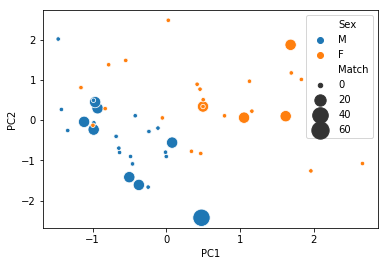

In [12]:
ax = sns.scatterplot(data=res, x="PC1", y="PC2", hue="Sex", size="Match", sizes=(20,300))

This plot shows the training dataset as tiny spots. Larger spots are the ones that have been used as test and correctly predicted. The biggest ones are the ones whose prediction does not match the labels.
As the dataset is split randomly each time, results and predictions may vary in your analysis (in mine, I've set the random number generator seed, so each time the random choices will be the same).


It looks like the algorithm misdiagnosed that large male in the middle of the plot as a female: anyway, it would have been tough even for a human!

In [13]:
# let's see where test and predicted labels differ

print("Point", "Truth", "Pred", "Match", sep=sep)
for i, elems in enumerate(zip(
    ["M" if x == 0 else "F" for x in test_labels],
    ["M" if x == 0 else "F" for x in pred_labels]
)):
    t, p = elems
    if t != p:
        error = "MISPREDICTION!"
    else:
        error = ""
        
    print(i, t, p, error, sep=sep)

Point	Truth	Pred	Match
0	M	M	
1	M	M	
2	F	F	
3	F	F	
4	M	M	
5	M	M	
6	M	F	MISPREDICTION!
7	M	M	
8	F	F	
9	M	M	
10	F	F	
11	M	M	


#### Plotting the decision surface

Last, we can actually visualize the decision boundary of the machine learning algorithm. There's no need to get mad and implement that ourselves, as *mlxtend* does the job for us. It needs the original data and our trained classifier, and its use is super easy.

You can install it via the command line:

`pip install mlxtend`

Here's some lines that I'm packing into a function for later use.

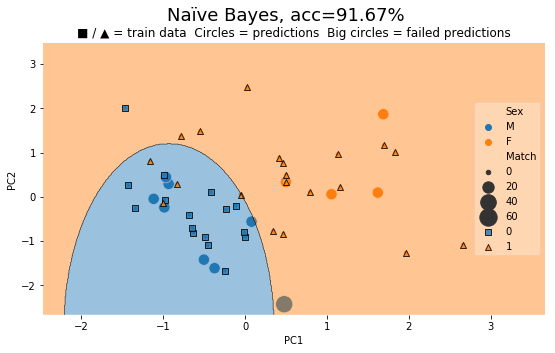

In [14]:
from mlxtend.plotting import plot_decision_regions

# see comments for the previous function! :)
suptitle = f"Naïve Bayes, acc={round(acc*100, 2)}%"
def plot_results():
    fig = plt.figure(figsize=(9,5))
    fig.suptitle(suptitle, size=18)
    ax = sns.scatterplot(data=res, x="PC1", y="PC2", hue="Sex", size="Match", sizes=(20,300))
    ax.set_title("■ / ▲ = train data  Circles = predictions  Big circles = failed predictions")
    plot_decision_regions(train_data, np.array(train_labels), clf=clf, legend=5)
    
    # train_data and train_labels are the X and y parameters that plot_decision_regions()
    # expects. The y can't just be a listlike element: we must convert it into a np-array

plot_results()

That was the reason that male was mispredicted as female!

### SVM (Support Vector Machines)

We now go over the algorithms quicker, as the same general scheme is followed.

Note that SVM expects that the data is *linearly separable*. When it is not, tricks can be employed to make it linearly separable (i.e. squaring variables, taking the modulus of variables, and so on.). These are referred to as *kernel tricks*. Try some different to find the one that suits your data the most!

In [15]:
from sklearn.svm import SVC

# training
clf = SVC(kernel="linear")
clf.fit(train_data, train_labels)

# predicting
pred_labels = clf.predict(test_data)

# testing the accuracy of predictions
acc = accuracy_score(pred_labels, test_labels)
print(round(acc*100, 2), "%", sep="")

100.0%


Yay! This time we got everything done right! Let's see how the decision boundary looks like.

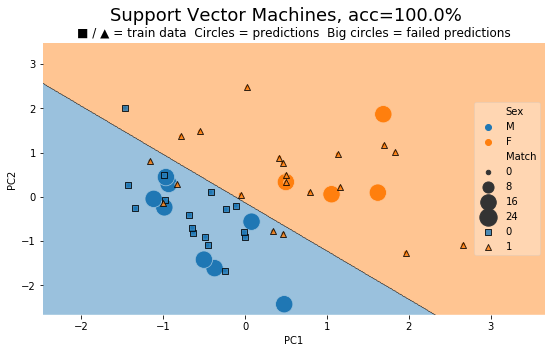

In [16]:
res = repack_results()

suptitle = f"Support Vector Machines, acc={round(acc*100, 2)}%"
plot_results()

We're now trying with a new kernel. From the doc:

> Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. 

Conveniently, *callable* is a custom function. We're going to stick with builtin ones for now ;)

In [17]:
# SVC training with another kernel

# training
clf = SVC(kernel="rbf", gamma="scale")
clf.fit(train_data, train_labels)

# predicting
pred_labels = clf.predict(test_data)

# testing the accuracy of predictions
acc = accuracy_score(pred_labels, test_labels)
print(round(acc*100, 2), "%", sep="")

100.0%


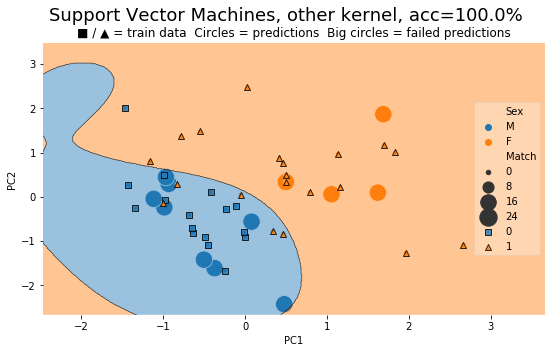

In [18]:
res = repack_results()

suptitle = f"Support Vector Machines, other kernel, acc={round(acc*100, 2)}%"
plot_results()

As you can see, kernel tricks do play a **huge** role in defining SVM behavior!

Other parameters that should be taken into account are *C* and *gamma*. Roughly, *C* controls the tradeoff between having a smooth decision boundary and classifying the points correctly. Whereas, *gamma* defines how far each single training point weighs into defining the decision boundary.

As always, get your hands dirty into changing parameters and see how they shape the results and the decision boundary.

Please note that classifying correctly all the points, at the cost of generating a very wiggly decision boundary, is _**not**_ what we aim at. Tweaking the parameters too much can result in **overfitting**, which should be avoided.

#### Small recap of important SVM parameters

kernel

C

gamma

### Decision Tree

Decision Tree is a really interesting algorithm that "grows" trees based on decisions, which tries to obtain, iteration through iteration, subsets as *pure* as possible. Each tree has *branches* and *leaves*, whose number can be tuned its behavior.

In [19]:
from sklearn import tree

# training
clf = tree.DecisionTreeClassifier()
clf.fit(train_data, train_labels)

# predicting
pred_labels = clf.predict(test_data)

# testing the accuracy of predictions
acc = accuracy_score(pred_labels, test_labels)
print(round(acc*100, 2), "%", sep="")

75.0%


Well, well. Depending on the run, I usually get 75% to 83% accuracy. Why is this changing? Because decision trees are grown randomly, and the final predictor can change even if tranied with the same data!

The classifier has the *random_state* parameter, that can be used to seed the random number generator and obtain reproducible results (not done by me in this example).

Let's plot:

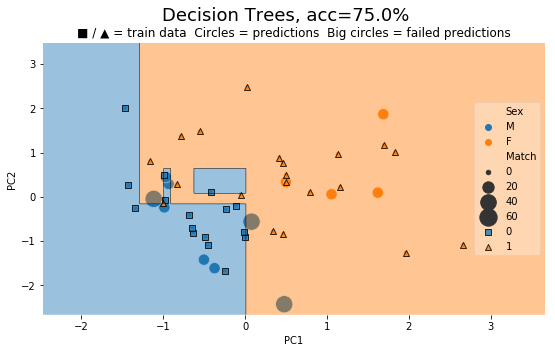

In [20]:
res = repack_results()

suptitle = f"Decision Trees, acc={round(acc*100, 2)}%"
plot_results()

In this case, 2 or 3 samples have been incorrectly predicted. As we discussed briefly, the algorithm can be tuned in different ways:

- Adjusting the number of leaves. Each "leaf" is a sample at the end of all iterations. It defaults to 1, but it can be increased via *min_samples_leaf*
- Choosing when stop splitting. Many branches are created as long as there are samples that remain to be split. The parameter *min_samples_split* sets the number of samples below which the algorithm would refrain from splitting data further. It sorta complements the previous parameter.
- Tweaking the splitting algorithm, the criteria used, the allowed number of branches, iterations, and so on.

Please do refer to the excellent *sklearn* doc for both algorithm explanation and the many other parameters.

## Random Forest

This algorithm leverages on the latter. It is an _**ensemble method**_, as it uses many times another classificator (in this case, Decision Tree) on a subset of data, then chooses the answer for predicting new data that's more likely among the host of miniclassificators.
Aptly, it's been called Random Forest.

In [21]:
from sklearn.ensemble import RandomForestClassifier

# training
clf = RandomForestClassifier(n_estimators=100)
clf.fit(train_data, train_labels)

# predicting
pred_labels = clf.predict(test_data)

# testing the accuracy of predictions
acc = accuracy_score(pred_labels, test_labels)
print(round(acc*100, 2), "%", sep="")

91.67%


*n_estimators* clearly sets the size of the forest ;)

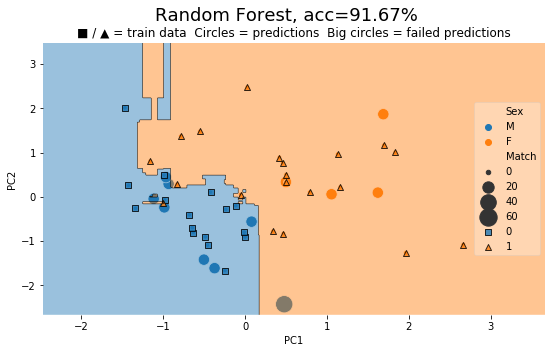

In [22]:
res = repack_results()

suptitle = f"Random Forest, acc={round(acc*100, 2)}%"
plot_results()

Many parameters have a 1-to-1 correspondence with Decision Tree algorithm. Let's see if we can tweak it a bit:

In [23]:
clf = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=2,# default is good in this case
    min_samples_leaf=1, # default is good in this case
    min_impurity_decrease=.01,
    random_state=123456
)

clf.fit(train_data, train_labels)

# predicting
pred_labels = clf.predict(test_data)

# testing the accuracy of predictions
acc = accuracy_score(pred_labels, test_labels)
print(round(acc*100, 2), "%", sep="")

91.67%


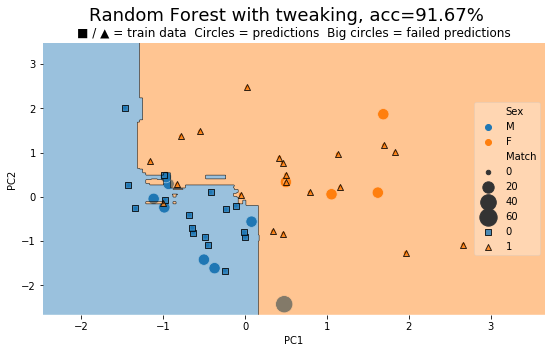

In [24]:
res = repack_results()

suptitle = f"Random Forest with tweaking, acc={round(acc*100, 2)}%"
plot_results()

## Adaboost

Adaboost, short for *adaptive boosting*, is another _**ensemble method**_ as it can use other machine learning algorithms of choice to make final decisions about new data.

The algorithm of choice defaults to Decision Tree, here's how to swith it towards another algorithm, like the first we saw, Gaussian Naïve Bayes:

In [25]:
from sklearn.ensemble import AdaBoostClassifier

# training
clf = AdaBoostClassifier(
    base_estimator=GaussianNB(),
    n_estimators=200
)
clf.fit(train_data, train_labels)

# predicting
pred_labels = clf.predict(test_data)

# testing the accuracy of predictions
acc = accuracy_score(pred_labels, test_labels)
print(round(acc*100, 2), "%", sep="")

100.0%


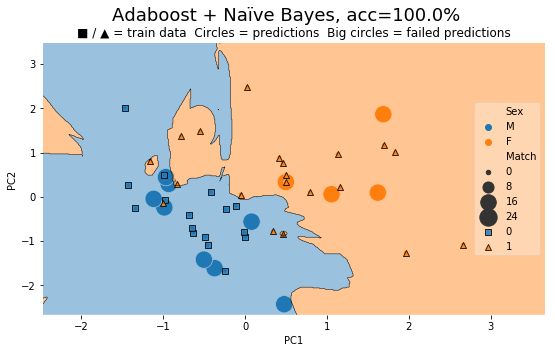

In [26]:
res = repack_results()

suptitle = f"Adaboost + Naïve Bayes, acc={round(acc*100, 2)}%"
plot_results()

And that, my friends, is **overfitting**! I've done it on purpose. O:) We got all our predictions right, but maybe, this is not the decision surface that's best for our data.

## KNN

KNN's not a secret set, it stands for K-nearest neighbor. While described as "the most simple" ML algorithm, that is not apparent in its Wikipedia description. Let's get to the syntax:

In [27]:
from sklearn.neighbors import KNeighborsClassifier as KNN

# training
clf = KNN()
clf.fit(train_data, train_labels)

# predicting
pred_labels = clf.predict(test_data)

# testing the accuracy of predictions
acc = accuracy_score(pred_labels, test_labels)
print(round(acc*100, 2), "%", sep="")

100.0%


Pretty interesting, out of the box.

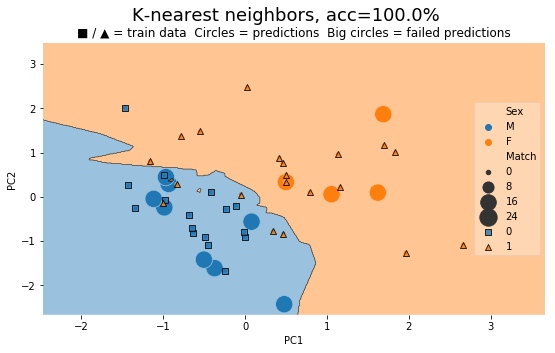

In [29]:
res = repack_results()

suptitle = f"K-nearest neighbors, acc={round(acc*100, 2)}%"
plot_results()

This ends our little syntax tour towards analyzing our data with *sklearn* and supervised classification algorithms.
I would recommend you to read about the *logic* each classificator uses, even if it is not necessary to understand all the math (as it is not necessary to being able coding in C to use any operating system).

Thank you for bearing with me all along!

## Final remarks:

- RTFM! always. (read the freakin' manual - aka the doc)


- Actively play with your data. Change parameters. Break things and see what happens.


- Do not take all these examples (on such a limited dataset) as an algorithm *competition*. There's no such thing as best algorithm, every situation needs a different approach.


- Every algorithm has a parameter space. *Finding the best one is the art at the bottom of machine learning*.


- There'll be people tampering with your data, but they **do not care** and **they make mistakes they don't care about**. Be in control of your data!